# Preparations

In [1]:
import Pkg
Pkg.DEFAULT_IO[] = stdout;

#### Fetch General Project Files


In [2]:
include("../Codebase/Functions/file_managment_functions.jl");
include("../Codebase/Functions/model_structure.jl");
include("../Codebase/Functions/plotting_functions.jl");
include("../Codebase/Functions/simulation_functions.jl");
include("../Codebase/Functions/steady_state_functions.jl");
include("../Codebase/Functions/make_bifurcation_diargam.jl");

#### Fetch Specific Project Files

In [3]:
include("Functions/models.jl");
include("Functions/basic_utility_functions.jl");
include("Functions/simulation_functions.jl");
include("Functions/basic_plotting_functions.jl");
include("Functions/data_handling_functions.jl");
include("Functions/behaviour_plotting_functions.jl");
include("Functions/occurrence_analysis_functions.jl");

#### Plot settings

In [4]:
gr(); 
mm = Plots.mm
default(fmt = :png,framestyle=:box,grid=false,xguidefontsize=16,yguidefontsize=16,titlefontsize=18);

In [5]:
red_scale_4 = [RGB{Float64}(1.0,0.6,0.6),RGB{Float64}(1.0,0.4,0.4),RGB{Float64}(1.0,0.2,0.2),RGB{Float64}(0.66,0.,0.),RGB{Float64}(0.33,0.,0.)];
green_blue_scale_4 = [RGB{Float64}(0.,1.,0.0),RGB{Float64}(0.,0.66,0.33),RGB{Float64}(0.,0.33,0.66),RGB{Float64}(0.4,0.4,1.)];
blue_scale_3 = [RGB{Float64}(0.,0.7,0.7) RGB{Float64}(0.,.0,1.) RGB{Float64}(0.7,0.0,0.7)];

#### Sets dataset parameter

In [6]:
target_folder = "BehaviourMap"

S_grid = 10 .^(range(-1,stop=2,length=300))
D_grid = 10 .^(range(-1,stop=2,length=300))
τ_grid = [0.1,0.15,0.20,0.30,0.50,0.75,1.0,1.5,2.0,3.0,5.0,7.50,10.0,15.0,20.0,30.0,50.0,75.0,100.0]
v0_grid = [0.01,0.02,0.03,0.05,0.075,0.1,0.15,0.20]
n_grid = [2.0,3.0,4.0]
η_grid = [0.001,0.002,0.005,0.01,0.02,0.05,0.1]

dataset = DataSet(target_folder,S_grid,D_grid,τ_grid,v0_grid,n_grid,η_grid);

### Declare model (for fast simulation initialisation)

In [7]:
function genSigModel!(dz, z, p, t)
    S, D, τ, v0, n, η = p
    σ,A1,A2,A3 = z

    dz[1] = v0 + ((S*σ)^n)/((S*σ)^n + (D*A3)^n + 1) - σ
    dz[2] = (σ-A1)/τ
    dz[3] = (A1-A2)/τ
    dz[4] = (A2-A3)/τ
    dz
end;

# Scan oscillation stabiltiy coexistence

In [8]:
# Declare scanning functions.
function term_sim(ss)
    condition(u,t,integrator) = norm(ss .- u) < 0.001
    affect!(integrator) = terminate!(integrator)
    cb = DiscreteCallback(condition,affect!) 
end
oprob_org = ODEProblem(genSigModel!,fill(0.0,4),(0.0,5000.0),fill(0.0,6))
function get_osc_fp_data(p)
    rts = sys_roots(model3,p)
    (length(rts)>1) && return (false,rts[1][1])
    stab = maximum(real.(eigen(sys_Js[3](rts[1],p)).values)) < 0
    (stab != true) && return (false,rts[1][1])
    ft = solve(remake(oprob_org;u0=fill(p[4],4),p=p),Rosenbrock23(),callback=term_sim(rts[1])).t[end]
    return (ft == 5000.0,rts[1][1])
end;

In [10]:
@time for τ in dataset.τ_grid
    osc_fp_data = Dict{Vector{Float64}, Tuple{Tuple{Bool, Float64}, Symbol}}()
    @time for v0 in dataset.v0_grid, n in dataset.n_grid, η in dataset.η_grid
        bg = BehaviourGrid([τ,v0,n,η],dataset);
        !bg.file_existed && error("Try to read faulty file, this might scew the results")
        for (Si,S) in enumerate(S_grid), (Di,D) in enumerate(D_grid)
            osc_fp_data[[S,D,τ,v0,n,η]] = (get_osc_fp_data([S,D,τ,v0,n,η]), bg.behaviours[Si,Di]) 
        end
    end
    serialize("Data/Oscillation_stability_coexistence/long_osc_τ_$(τ).jls",osc_fp_data)
end

1833.735626 seconds (6.22 G allocations: 459.626 GiB, 45.62% gc time, 0.03% compilation time)
1456.551109 seconds (6.32 G allocations: 464.915 GiB, 31.07% gc time)
1905.233907 seconds (6.43 G allocations: 471.486 GiB, 45.90% gc time)
1892.230891 seconds (6.68 G allocations: 485.110 GiB, 44.98% gc time)
2007.042114 seconds (7.53 G allocations: 532.375 GiB, 44.18% gc time)
2270.219749 seconds (8.98 G allocations: 612.963 GiB, 43.55% gc time)
2497.648945 seconds (10.24 G allocations: 683.622 GiB, 41.94% gc time)
2864.661258 seconds (12.23 G allocations: 790.375 GiB, 41.62% gc time)
3262.555667 seconds (13.72 G allocations: 867.209 GiB, 43.58% gc time)
2948.392197 seconds (15.19 G allocations: 952.993 GiB, 31.23% gc time)
3722.251165 seconds (15.88 G allocations: 1001.252 GiB, 43.54% gc time)
3712.853597 seconds (15.74 G allocations: 994.250 GiB, 43.63% gc time)
2911.329610 seconds (15.22 G allocations: 951.498 GiB, 29.78% gc time)
3333.198202 seconds (14.31 G allocations: 903.021 GiB, 41.

# Analysis

In [23]:
@time for τ in dataset.τ_grid
    c1 = count(first.(collect(values(deserialize("Data/Oscillation_stability_coexistence/osc_τ_$(τ).jls")))))
    c2 = count(first.(collect(values(deserialize("Data/Oscillation_stability_coexistence/long_osc_τ_$(τ).jls")))))
    println(c1,"   ",c2)
end

7   0
7   0
21   14
420   406
3213   3185
10367   9835
17703   17591
33362   32809
48895   48006
74305   72408
108150   105462
137417   133686
156212   151361
184527   177863
201656   192003
230804   214711
265601   230139
310667   245644
361053   260981
2675.700377 seconds (2.30 G allocations: 177.094 GiB, 23.14% gc time)


In [11]:
@time begin 
    osc_fp_data = deserialize("Data/Oscillation_stability_coexistence/long_osc_τ_$(τ_grid[1]).jls");
    foreach(τ -> merge!(osc_fp_data,deserialize("Data/Oscillation_stability_coexistence/long_osc_τ_$(τ).jls")), τ_grid[2:end]);
end

2611.676297 seconds (2.01 G allocations: 149.892 GiB, 50.14% gc time, 0.00% compilation time)


In [12]:
vals = collect(values(osc_fp_data));

In [13]:
behaviour_list = unique(last.(vals));
behaviour_counts = sort(map(behaviour -> behaviour=>count(last.(vals) .== behaviour), behaviour_list);by=x->x[2])

10-element Vector{Pair{Symbol, Int64}}:
                :stochastic_switching => 294741
               :single_response_pulse => 663459
             :stochastic_anti_pulsing => 1878160
            :heterogeneous_activation => 2152878
                  :stochastic_pulsing => 3631527
 :homogeneous_intermediate_activation => 4729058
                  :stable_bistability => 10644694
                         :oscillation => 16395331
              :homogeneous_activation => 98988347
                       :no_activation => 147901805

In [37]:
osc_stab_co = filter(x->x[2][1][1],osc_fp_data);
osc_stab_co_behaviours = last.(values(osc_stab_co))
osc_stab_b_counts = sort(map(behaviour -> behaviour=>count(osc_stab_co_behaviours .== behaviour), unique(osc_stab_co_behaviours));by=x->x[2]);

In [48]:
osc_active_c = count(map(k -> osc_stab_co[k][1][2] > (1.0+k[4])/2, collect(keys(osc_stab_co))))
osc_inactive_c = length(osc_stab_co) - osc_active_c
(osc_active_c,osc_inactive_c);

In [49]:
sort(vcat(behaviour_counts[1:end-2],[:oscillation_active_state=>osc_active_c,:oscillation_inactive_state=>osc_inactive_c]);by=x->x[2])

10-element Vector{Pair{Symbol, Int64}}:
                :stochastic_switching => 294741
               :single_response_pulse => 663459
          :oscillation_inactive_state => 702863
            :oscillation_active_state => 1193241
             :stochastic_anti_pulsing => 1878160
            :heterogeneous_activation => 2152878
                  :stochastic_pulsing => 3631527
 :homogeneous_intermediate_activation => 4729058
                  :stable_bistability => 10644694
                         :oscillation => 16395331

## Example of behaviours

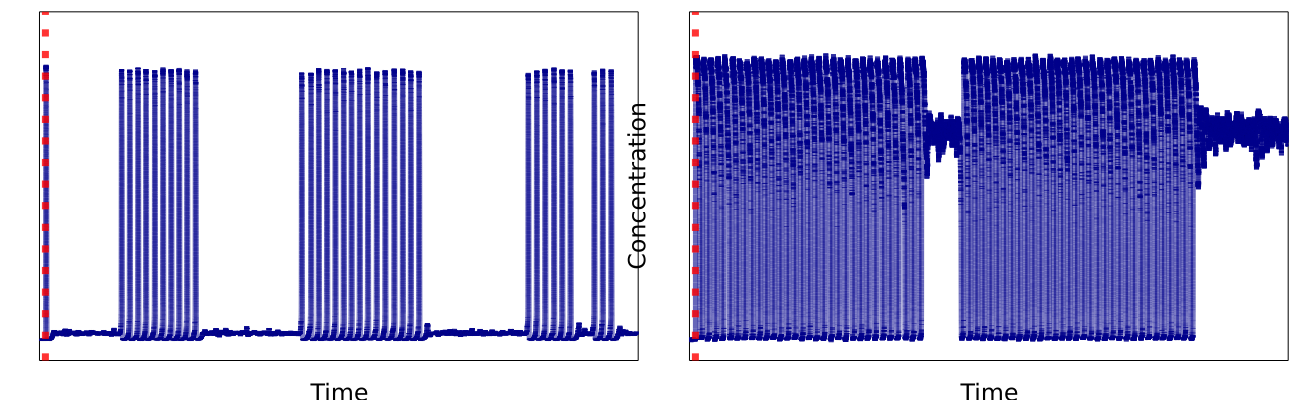

In [140]:
l = 10000.0
parameters_stoch_pulsing_inactive = [10., 35.2, 15.0, 0.075, 3.0, 0.005];
parameters_stoch_anti_pulsing_active = [50.5, 35.2, 15.0, 0.075, 3.0, 0.01];
p1 = plot_activation(parameters_stoch_pulsing_inactive,100.0,l,vars=[1],color_prestress=[:darkblue],ymax=1.25,lw=5)
p2 = plot_activation(parameters_stoch_anti_pulsing_active,100.0,l,vars=[1],color_prestress=[:darkblue],ymax=1.25,lw=5)
behaviour_examples = plot(p1,p2,size=(1300,400),bottom_margin=5mm,left_margin=5mm)

In [148]:
save_figure(behaviour_examples,"Oscillation_Stability_Coexistence";tag="behaviour_examples_")

### Behaviour map

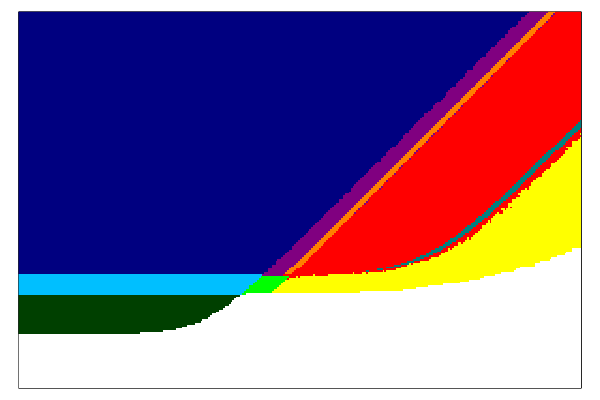

In [153]:
params = [5.0,0.05,3,0.05];
bg = BehaviourGrid(params,dataset);
color_osc_in = RGB{Float64}(0.0,0.5,0.5)
color_osc_act = RGB{Float64}(1.0,0.5,0.0)
color_grid = get_color.(bg.behaviours)
for (Si,S) in enumerate(S_grid), (Di,D) in enumerate(D_grid)
    if osc_fp_data[[S,D,params...]][1][1]
        color_grid[Si,Di] = ((osc_fp_data[[S,D,params...]][1][2] > (1.0+params[2])/2) ? color_osc_act : color_osc_in)
    end
end
behaviour_map = plot(color_grid[100:end,:],yflip=false,size=(600,400),xticks=[],yticks=[])

In [154]:
save_figure(behaviour_map,"Oscillation_Stability_Coexistence";tag="behaviour_map_")